# Data 301 Project - Shows Commonly Watched Together by Individual Viewers
**In this project I will answer the question of:**  
*Which shows are commonly watched together by users, and what insights do the
association rules reveal about viewing behaviour?*

> Note: insights into viewing behaviour and other conclusions are avaliable in the final report.

**Method:**  
*The Apriori algorithm will be applied to extract frequent itemsets and generate rules with confidence and support thresholds.*


## Setup
I have used and filtered a dataset from grouplens https://grouplens.org/datasets/movielens/ specifically the movielens dataset containing 330,975 users.

In [47]:
# Set up ---------------------------------------------------------------------------------------------------------------

import dask.dataframe as dd
from dask import bag as db
import matplotlib.pyplot as plt
import numpy as np

!pip install gdown
!gdown -O movie_data.zip 'https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C'
!unzip movie_data.zip


def load_data(num_users, num_movies):
    movies_dd = dd.read_csv("movies.csv")
    ratings_dd = dd.read_csv("ratings.csv")

    top_movies = movies_dd["movieId"].drop_duplicates().compute().values[:num_movies]
    top_movies_set = set(top_movies)

    filt_ratings = ratings_dd[ratings_dd["movieId"].isin(top_movies_set)]

    unique_users = filt_ratings["userId"].drop_duplicates().compute().values[:num_users]
    unique_users_set = set(unique_users)
    filt_ratings = filt_ratings[filt_ratings["userId"].isin(unique_users_set)].drop_duplicates(subset=["userId", "movieId"])

    filt_ratings_pd = filt_ratings.compute()

    # Index mapping
    sorted_users = np.sort(unique_users)
    sorted_movies = np.sort(top_movies)
    user_indices = np.searchsorted(sorted_users, filt_ratings_pd["userId"].values)
    movie_indices = np.searchsorted(sorted_movies, filt_ratings_pd["movieId"].values)

    # Creates binary watch arrays for each user
    watch_matrix = np.zeros((len(sorted_users), len(sorted_movies)), dtype=int)
    watch_matrix[user_indices, movie_indices] = 1

    user_show_list = list(zip(sorted_users, watch_matrix))
    user_show_ratings_bag = db.from_sequence(user_show_list)

    movies_dict = movies_dd.compute().set_index("movieId")["title"].to_dict()
    show_titles = [movies_dict[m] for m in sorted_movies]
    show_names_bag = db.from_sequence(list(enumerate(show_titles)))

    return user_show_ratings_bag, show_names_bag


user_show_ratings_bag, show_names_bag = load_data(330975, 100)
# ----------------------------------------------------------------------------------------------------------------------

Downloading...
From (original): https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C
From (redirected): https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C&confirm=t&uuid=8a3bdf04-2fd1-4a1b-abd6-9893a9719f36
To: /content/movie_data.zip
100% 938M/938M [00:17<00:00, 54.3MB/s]
Archive:  movie_data.zip
replace movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Applying The Method

In [48]:
# A-priori Algorithm ---------------------------------------------------------------------------------------------------

def generate_frequent_pairs(watched_indices, above_threshold):
    # Above_threshold is the list of show indices that individually had supports > 100
    def generate_pairs(show_indices):
        pairs = []
        show_indices = list(show_indices)   # The indices of shows that were watched by a viewer e.g. [1, 3, 5]
        for i in range(len(show_indices)):
            for j in range(i + 1, len(show_indices)):
                if show_indices[i] in above_threshold and show_indices[j] in above_threshold:
                    pairs.append(tuple(sorted((show_indices[i], show_indices[j]))))
        return pairs

    pair_bag = watched_indices.map(generate_pairs).flatten()
    return pair_bag.frequencies()


def a_priori(user_show_bag, support=100):
    # Step 1: Extract watched show indices (indices where value = 1), then flatten the output
    watched_indices = user_show_bag.map(lambda x: [index for index, val in enumerate(x[1]) if val == 1])
    flattened_watched_indices = watched_indices.flatten()

    # Step 2: Get shows watched individually over 100 (threshold) times
    show_frequencies = flattened_watched_indices.frequencies()
    shows_above_threshold = show_frequencies.filter(lambda x: x[1] >= support).map(lambda x: x[0]).compute()

    # Step 3: Get frequent pairs
    pair_counts = generate_frequent_pairs(watched_indices, set(shows_above_threshold))
    return pair_counts

# ----------------------------------------------------------------------------------------------------------------------

In [49]:
# ----- Get frequent item pairs ------------------------------------------------------------------------------------
frequent_pairs = a_priori(user_show_ratings_bag, support=100)
print(frequent_pairs.take(10))
# ------------------------------------------------------------------------------------------------------------------

(((0, 1), 19366), ((0, 5), 18250), ((0, 9), 18304), ((0, 10), 10648), ((0, 16), 13755), ((0, 18), 14363), ((0, 20), 13866), ((0, 24), 14659), ((0, 30), 5293), ((0, 33), 22608))


In [50]:
# ----- Convert frequent item pair numbers to actual movie names ---------------------------------------------------
show_names_list = show_names_bag.map(lambda x: x[1]).compute()  # Just get show names

frequent_pairs_list = frequent_pairs.compute()

named_pairs = []
for (i, j), count in frequent_pairs_list:
    name_i = show_names_list[i]
    name_j = show_names_list[j]
    named_pairs.append(((name_i, name_j), count))

# Show top 10
for (show_a, show_b), count in named_pairs[:10]:
    print(f"{show_a} & {show_b} — watched together by {count} users")
# ------------------------------------------------------------------------------------------------------------------

Toy Story (1995) & Jumanji (1995) — watched together by 19366 users
Toy Story (1995) & Heat (1995) — watched together by 18250 users
Toy Story (1995) & GoldenEye (1995) — watched together by 18304 users
Toy Story (1995) & American President, The (1995) — watched together by 10648 users
Toy Story (1995) & Sense and Sensibility (1995) — watched together by 13755 users
Toy Story (1995) & Ace Ventura: When Nature Calls (1995) — watched together by 14363 users
Toy Story (1995) & Get Shorty (1995) — watched together by 13866 users
Toy Story (1995) & Leaving Las Vegas (1995) — watched together by 14659 users
Toy Story (1995) & Dangerous Minds (1995) — watched together by 5293 users
Toy Story (1995) & Babe (1995) — watched together by 22608 users


In [51]:
# ----- Association rules ------------------------------------------------------------------------------------------
def generate_rules(pair_counts, item_supports, min_confidence=0.7):
    rules = []
    for (a, b), support_ab in pair_counts:
        support_a = item_supports.get(a, 0)
        support_b = item_supports.get(b, 0)
        if support_a > 0:   # # If they watched a then we have x confidence they have watched b (a -> b)
            conf_a_to_b = support_ab / support_a
            if conf_a_to_b >= min_confidence:
                rules.append(((a, b), conf_a_to_b, support_ab))
        if support_b > 0:   # If they watched b then we have x confidence they have watched a (b -> a)
            conf_b_to_a = support_ab / support_b
            if conf_b_to_a >= min_confidence:
                rules.append(((b, a), conf_b_to_a, support_ab))
    return rules


# Get individual supports
item_supports = user_show_ratings_bag.map(lambda x: set(x[1].nonzero()[0])).flatten().frequencies().compute()

# Create rules
rules = generate_rules(frequent_pairs, dict(item_supports), min_confidence=0.7)
named_rules = [((show_names_list[a], show_names_list[b]), conf, support) for ((a, b), conf, support) in rules]

# Print top 10
for (a, b), conf, support in named_rules[:10]:
    print(f"If a user watches '{a}', they also watch '{b}' with confidence {conf:.2f} (support={support})")
# ------------------------------------------------------------------------------------------------------------------

If a user watches 'Fair Game (1995)', they also watch 'GoldenEye (1995)' with confidence 0.75 (support=1045)
If a user watches 'Assassins (1995)', they also watch 'Seven (a.k.a. Se7en) (1995)' with confidence 0.74 (support=3773)
If a user watches 'Fair Game (1995)', they also watch 'Seven (a.k.a. Se7en) (1995)' with confidence 0.75 (support=1038)
If a user watches 'Sudden Death (1995)', they also watch 'Broken Arrow (1996)' with confidence 0.74 (support=3378)
If a user watches 'Four Rooms (1995)', they also watch 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)' with confidence 0.72 (support=4807)
If a user watches 'Sudden Death (1995)', they also watch 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)' with confidence 0.70 (support=3206)
If a user watches 'Dead Presidents (1995)', they also watch 'Seven (a.k.a. Se7en) (1995)' with confidence 0.72 (support=1924)
If a user watches 'Dead Presidents (1995)', they also watch 'Usual Suspects, The (1995)' with confidence 0.74 (support=1966)
If a user wat

# Displaying The Data

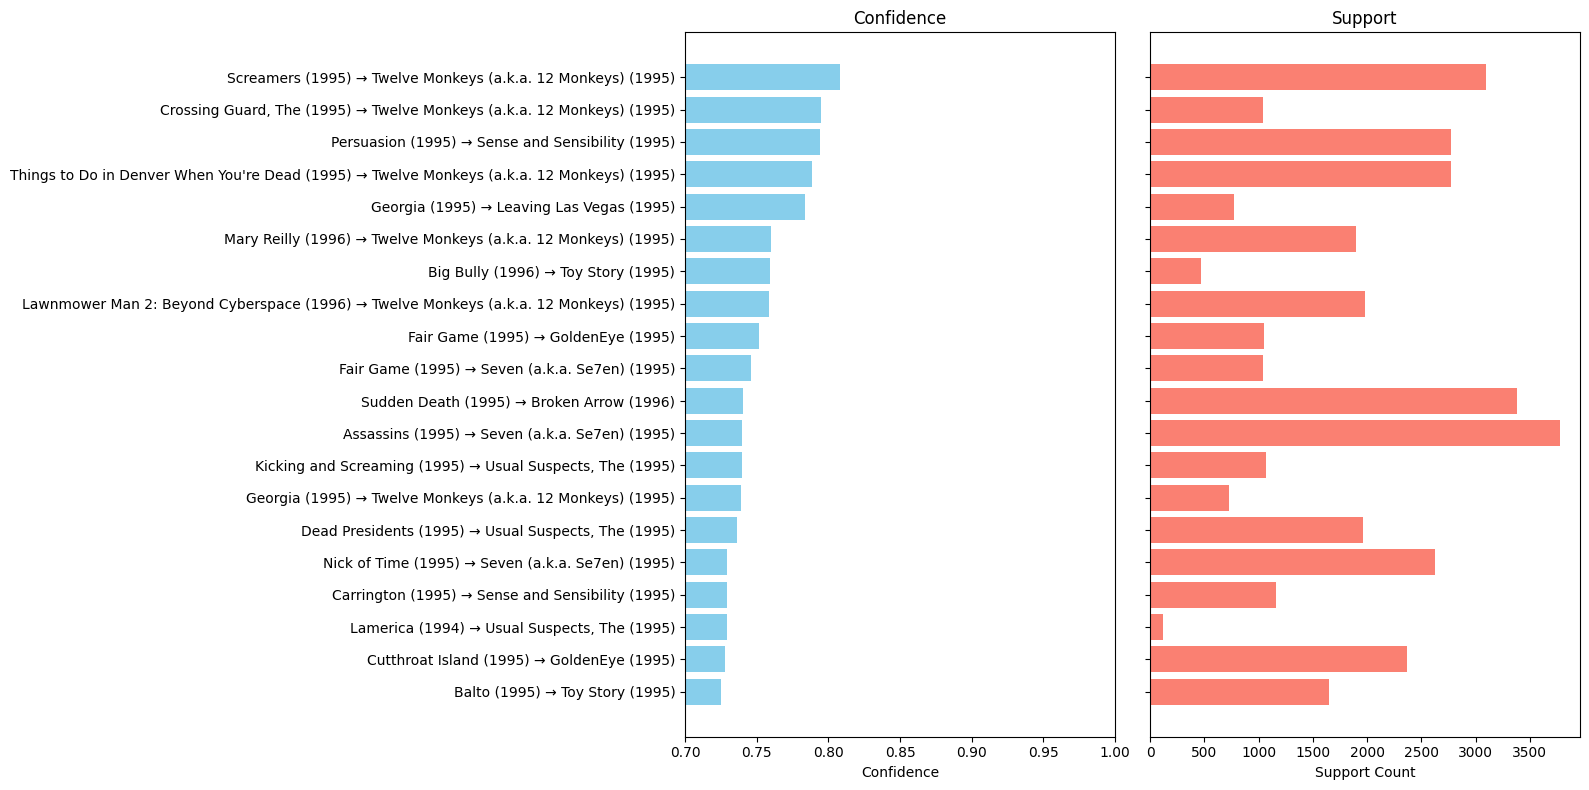

In [52]:
# ----- Graphing the data ------------------------------------------------------------------------------------------
top_rules = sorted(named_rules, key=lambda x: x[1], reverse=True)[:20]

labels = [f"{a} → {b}" for (a, b), _, _ in top_rules]
confidences = [conf for (_, _), conf, _ in top_rules]
supports = [support for (_, _), _, support in top_rules]

# Make confidence and support graphs display next to each other
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

# Confidence graph
axes[0].barh(labels[::-1], confidences[::-1], color='skyblue')
axes[0].set_title("Confidence")
axes[0].set_xlabel("Confidence")
axes[0].set_xlim(0.7, 1.0)

# Support graph
axes[1].barh(labels[::-1], supports[::-1], color='salmon')
axes[1].set_title("Support")
axes[1].set_xlabel("Support Count")

plt.tight_layout()
plt.show()
# ------------------------------------------------------------------------------------------------------------------

#Saving my Algorithm for use in Google Cloud
> Note: I refactored my generate_frequent_pairs function here to increase its efficiency.

In [43]:
%%writefile cowatched_film_rules.py
from dask.distributed import LocalCluster, Client
import dask.dataframe as dd
from dask import bag as db
import numpy as np
import multiprocessing
import sys
import os
import time

def load_data(num_users, num_movies):
    print("Loading data...")
    movies_dd = dd.read_csv("movies.csv")
    ratings_dd = dd.read_csv("ratings.csv")

    top_movies = movies_dd["movieId"].drop_duplicates().compute().values[:num_movies]
    top_movies_set = set(top_movies)

    filt_ratings = ratings_dd[ratings_dd["movieId"].isin(top_movies_set)]

    unique_users = filt_ratings["userId"].drop_duplicates().compute().values[:num_users]
    unique_users_set = set(unique_users)
    filt_ratings = filt_ratings[filt_ratings["userId"].isin(unique_users_set)].drop_duplicates(subset=["userId", "movieId"])

    filt_ratings_pd = filt_ratings.compute()

    # Index mapping
    sorted_users = np.sort(unique_users)
    sorted_movies = np.sort(top_movies)
    user_indices = np.searchsorted(sorted_users, filt_ratings_pd["userId"].values)
    movie_indices = np.searchsorted(sorted_movies, filt_ratings_pd["movieId"].values)

    # Creates binary watch arrays for each user
    watch_matrix = np.zeros((len(sorted_users), len(sorted_movies)), dtype=int)
    watch_matrix[user_indices, movie_indices] = 1

    user_show_list = list(zip(sorted_users, watch_matrix))
    user_show_ratings_bag = db.from_sequence(user_show_list)

    movies_dict = movies_dd.compute().set_index("movieId")["title"].to_dict()
    show_titles = [movies_dict[m] for m in sorted_movies]
    show_names_bag = db.from_sequence(list(enumerate(show_titles)))

    return user_show_ratings_bag, show_names_bag

def generate_frequent_pairs(watched_indices, above_threshold):
    above_threshold = set(above_threshold)
    def generate_pairs(show_indices):
        filtered = list(filter(lambda x: x in above_threshold, show_indices))
        return [tuple(sorted((filtered[i], filtered[j])))
                for i in range(len(filtered)) for j in range(i + 1, len(filtered))]
    return watched_indices.map(generate_pairs).flatten().frequencies()

def a_priori(user_show_bag, support=100):
    watched_indices = user_show_bag.map(lambda x: [i for i, val in enumerate(x[1]) if val == 1])
    flattened = watched_indices.flatten()
    show_frequencies = flattened.frequencies()
    shows_above_threshold = show_frequencies.filter(lambda x: x[1] >= support).map(lambda x: x[0]).compute()
    pair_counts = generate_frequent_pairs(watched_indices, shows_above_threshold)
    return pair_counts

def generate_rules(pair_counts, item_supports, min_conf=0.7):
    rules = []
    for (a, b), support_ab in pair_counts:
        support_a, support_b = item_supports.get(a, 0), item_supports.get(b, 0)
        if support_a and support_ab / support_a >= min_conf:
            rules.append(((a, b), support_ab / support_a, support_ab))
        if support_b and support_ab / support_b >= min_conf:
            rules.append(((b, a), support_ab / support_b, support_ab))
    return rules

def run_algorithm(num_users, support_threshold, num_cpus):
    cluster = LocalCluster(n_workers=num_cpus, threads_per_worker=1)
    client = Client(cluster)

    print(f"\nRunning with {num_cpus} CPUs on {num_users} users")

    user_bag, show_bag = load_data(num_users, 100)
    show_names = show_bag.compute()

    start = time.time()
    pairs = a_priori(user_bag, support_threshold)
    pair_list = pairs.compute()

    item_supports = user_bag.map(lambda x: set(np.nonzero(x[1])[0])).flatten().frequencies().compute()
    rules = generate_rules(pair_list, dict(item_supports), 0.7)

    named_rules = [((show_names[a], show_names[b]), conf, support)
                   for ((a, b), conf, support) in rules]

    print("Top 3 rules:")
    for (a, b), conf, support in named_rules[:3]:
        print(f"If a user watches '{a}', they also watch '{b}' with confidence {conf:.2f} (support={support})")

    print(f"Completed {num_users} users with {num_cpus} CPUs in {time.time() - start:.2f}s\n")

    client.close()
    cluster.close()

if __name__ == "__main__":
    if not os.path.exists("movies.csv") or not os.path.exists("ratings.csv"):
        os.system("pip install -q gdown")
        os.system("gdown -O lab4_part1.zip 'https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C'")
        os.system("unzip -o lab4_part1.zip")

    support_threshold = 100

    args = sys.argv[1:]
    if len(args) % 2 == 1:
        support_threshold = int(args.pop())

    config_pairs = [(int(args[i]), int(args[i+1])) for i in range(0, len(args), 2)]

    for num_users, num_cpus in config_pairs:
        run_algorithm(num_users, support_threshold, num_cpus)


Overwriting cowatched_film_rules.py


## Create a Dataproc cluster
We will use Google Cloud's pre-built Dataproc cluster to make it easier to start a set of virtual machines in the cloud that can run our code. In this lab we will start one node that has 8 virtual CPUs.

> Credit: Lab 4 Code

In [14]:
USERNAME="scu39"
%env REGION=australia-southeast1
%env ZONE=australia-southeast1-a
%env PROJECT=data301-project-2025-$USERNAME
%env CLUSTER=data301-project-2025-$USERNAME-cluster

env: REGION=australia-southeast1
env: ZONE=australia-southeast1-a
env: PROJECT=data301-project-2025-scu39
env: CLUSTER=data301-project-2025-scu39-cluster


In [3]:
# Login to start cluster
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=DALcAJofxPs2C0ezBmCufLJAbRVnWg&prompt=consent&token_usage=remote&access_type=offline&code_challenge=NMkU3FnwuqFJurdql9jigLVKYOwP7dZn0RILS_tWeZo&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AUJR-x54UOlrAX53V8y10iXVWIWtNe-DH-7jiS4aNWp-d2jxIckbXzsLGzTHTZJfu7qn9g

You are now logged in as [sammycumins@gmail.com].
Your current project 

In [15]:
# Set which project and the environment
!gcloud config set project $PROJECT
!gcloud services enable dataproc.googleapis.com cloudresourcemanager.googleapis.com

Updated property [core/project].
Operation "operations/acat.p2-376076459448-d9e7af64-39a4-4710-8292-fd9402a2352e" finished successfully.


In [36]:
# Starts cluster
!gcloud dataproc clusters create $CLUSTER --region=$REGION --zone=$ZONE \
  --master-machine-type n2-standard-8 \
  --master-boot-disk-size 100 \
  --image-version 2.2-ubuntu22 \
  --max-age=30m \
  --public-ip-address \
  --num-masters=1 --num-workers=0

Waiting on operation [projects/data301-project-2025-scu39/regions/australia-southeast1/operations/9494c45a-6859-33d5-bb02-1f5b2f5464e7].

Created [https://dataproc.googleapis.com/v1/projects/data301-project-2025-scu39/regions/australia-southeast1/clusters/data301-project-2025-scu39-cluster] Cluster placed in zone [australia-southeast1-a].


# Make Files Accessible in Cloud

# Running the Code in the Cloud
### Scalability on a single processor (approx. 10 mins to run)

Most recent algorithm run times:

| Users Processed | CPUs Used | Time Taken (s) |
|---------------|----------|----------------|
| 41,250       | 1        | 62.98          |
| 82,500       | 1        | 96.26          |
| 165,000      | 1        | 149.86         |
| 330,000      | 1        | 166.53         |


In [40]:
run_presets = [41250, 1, 82500, 1, 165000, 1, 330000, 1]
run_preset_str = " ".join(map(str, run_presets))

command = f"gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION /content/cowatched_film_rules.py -- {run_preset_str} 100"
!{command}

Job [69f2f7f71922435b92c7eab9b26032ab] submitted.
Waiting for job output...
Downloading...
From (original): https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C
From (redirected): https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C&confirm=t&uuid=66aefdad-38aa-49f7-b480-dec76bf865e9
To: /tmp/69f2f7f71922435b92c7eab9b26032ab/lab4_part1.zip
100%|██████████| 938M/938M [00:23<00:00, 39.2MB/s]
Archive:  lab4_part1.zip
 extracting: movies.csv              
 extracting: ratings.csv             

Running with 1 CPUs on 41250 users
Loading data...
/opt/conda/default/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/default/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.88 MiB.
This may cause some slowdown.
Conside

### Weak Scalability (approx. 6 mins to run)

Most recent algorithm run times:

| Users Processed | CPUs Used | Time Taken (s) |
|---------------|----------|----------------|
| 41,250       | 1        | 62.98          |
| 82,500       | 2        | 70.28          |
| 165,000      | 4        | 84.35          |
| 330,000      | 8        | 85.57          |

In [41]:
run_presets = [82500, 2, 165000, 4, 330000, 8]
run_preset_str = " ".join(map(str, run_presets))

command = f"gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION /content/cowatched_film_rules.py -- {run_preset_str} 100"
!{command}

Job [8bcdbc3179e94d99bbcfc0f0ebfba6d3] submitted.
Waiting for job output...
Downloading...
From (original): https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C
From (redirected): https://drive.google.com/uc?export=download&id=11s0A5FwzYlwoy0zwSBhk74q5Db9y4_6C&confirm=t&uuid=75d67b94-4638-45cd-87e9-37bca4d014c7
To: /tmp/8bcdbc3179e94d99bbcfc0f0ebfba6d3/lab4_part1.zip
100%|██████████| 938M/938M [00:24<00:00, 38.6MB/s]
Archive:  lab4_part1.zip
 extracting: movies.csv              
 extracting: ratings.csv             

Running with 2 CPUs on 82500 users
Loading data...
/opt/conda/default/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 67.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/default/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 67.56 MiB.
This may cause some slowdown.
Conside

# Plotting Scalability Graphs

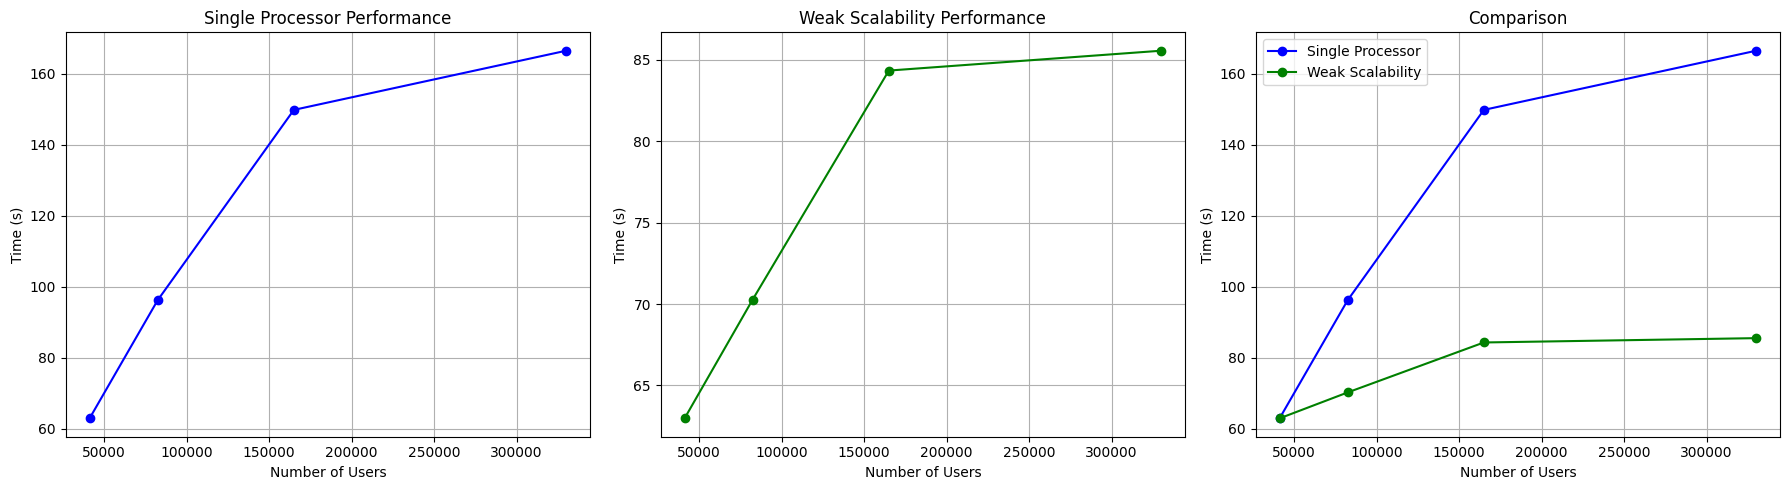

In [42]:
import matplotlib.pyplot as plt

users = [41250, 82500, 165000, 330000]
times_set1 = [62.98, 96.26, 149.86, 166.53]
times_set2 = [62.98, 70.28, 84.35, 85.57]

data_points = 8

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Single Processor
axs[0].plot(users[:data_points], times_set1[:data_points], marker='o', color='blue')
axs[0].set_title('Single Processor Performance')
axs[0].set_xlabel('Number of Users')
axs[0].set_ylabel('Time (s)')
axs[0].grid(True)

# Weak Scalability
axs[1].plot(users[:data_points], times_set2[:data_points], marker='o', color='green')
axs[1].set_title('Weak Scalability Performance')
axs[1].set_xlabel('Number of Users')
axs[1].set_ylabel('Time (s)')
axs[1].grid(True)

# Comparison
axs[2].plot(users[:data_points], times_set1[:data_points], marker='o', label='Single Processor', color='blue')
axs[2].plot(users[:data_points], times_set2[:data_points], marker='o', label='Weak Scalability', color='green')
axs[2].set_title('Comparison')
axs[2].set_xlabel('Number of Users')
axs[2].set_ylabel('Time (s)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()